# Recreating models with PyMC3

This notebook fits a switching model with StatsModels and then PyMC3

# Preparation

## Load libraries

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from datetime import datetime

import warnings

import statsmodels.api as sm

from pathlib import Path

In [2]:
import pymc3 as pm
import theano.tensor as tt
import arviz as az

In [3]:
sm.__version__, pm.__version__, az.__version__

('0.11.1', '3.8', '0.8.3')

In [ ]:
pd.plotting.register_matplotlib_converters()

## Load and prepare data

In [4]:
path_data = Path(".").absolute().parent / "data"
path_xl = path_data / "ESI_GDP.xlsx"

In [5]:
df = pd.read_excel(path_xl, index_col=[0], engine='openpyxl')
df.index = df.index.to_series().apply(lambda x: datetime.strptime(x, '%YM%m'))
df.dropna().head()

,GGDP,GESI,GESISA,GGDPSA
2006-05-01,110.800000,106.863298,106.816640,109.458524
2006-06-01,109.258365,106.396667,106.327908,109.290571
2006-07-01,109.859167,104.883275,104.541073,109.045494
2006-08-01,108.508595,101.666480,101.486939,109.335025
2006-09-01,107.968031,99.242416,101.525884,107.570909


In [6]:
data = pd.concat(
    [df["GGDP"].rename("ggdp"), df["GESI"].rename("gesi"), df["GESI"].tshift(4).rename("gesi[-4]")],
    axis="columns",
).dropna(axis="rows")
data["c"] = 1
data["t"] = range(len(data))
pd.concat([data.head(), data.tail()])

,ggdp,gesi,gesi[-4],c,t
2006-09-01,107.968031,99.242416,106.863298,1,0
2006-10-01,112.464148,105.045745,106.396667,1,1
2006-11-01,110.597609,102.958847,104.883275,1,2
2006-12-01,108.492818,105.941397,101.666480,1,3
2007-01-01,110.620000,105.439110,99.242416,1,4
2016-09-01,97.892436,103.963085,103.638347,1,120
2016-10-01,98.754294,102.285535,106.462025,1,121
2016-11-01,98.282574,102.560216,103.693651,1,122
2016-12-01,97.474446,106.682404,106.788580,1,123
2017-01-01,99.500001,108.382922,103.963085,1,124


## Split data (into training/validation, endog/exog)

In [7]:
cutoff = '2016-10-01'  # 4 periods at the end
cutoff_idx = np.argmax(data.index == cutoff)

train = data.index[:cutoff_idx]
valid = data.index[cutoff_idx:]

In [8]:
endog = data['ggdp']
exog = data[['c', 't', 'gesi[-4]']]

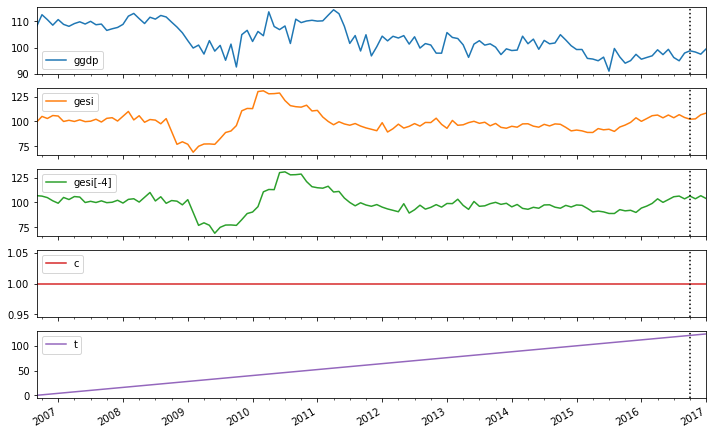

In [9]:
axs = data.plot.line(subplots=True, figsize=(12, 8))
for ax in axs:
    ax.axvline(cutoff, linestyle=':', color='black')

# Fit with `statsmodels`

## Create model

In [10]:
np.random.seed(22)

model_template = sm.tsa.MarkovRegression(
    endog=endog, k_regimes=2, exog=exog, trend=None
)

# Fit model only train data
mdl_sm = None
remaining_tries = 100
with warnings.catch_warnings():
    warnings.simplefilter("error", RuntimeWarning)
    while (mdl_sm is None) and (remaining_tries >= 0):
        try:
            mdl_sm = sm.tsa.MarkovRegression(
                endog=endog.loc[train],
                k_regimes=2,
                exog=exog.loc[train],
                trend=None,
            ).fit(search_reps=2000, em_iter=20, disp=True)
        except RuntimeWarning:
            remaining_tries -= 1

# Get coefficients
coef_sm = pd.DataFrame(
    {
        "value": mdl_sm.params,
        "std": pd.Series(np.sqrt(np.diag(mdl_sm.cov_params())), mdl_sm.params.index),
        "z": mdl_sm.tvalues,
    }
)

Optimization terminated successfully.
         Current function value: 2.418175
         Iterations: 33
         Function evaluations: 38
         Gradient evaluations: 38


## Get dataframe of predictions

In [11]:
# Get dataframe of predictions
pred_ins = pd.Series(
    mdl_sm.predict(),
    index=train,
    name="Conditional Mean (In-sample)",
)
pred_oos = pd.Series(
    model_template.predict(mdl_sm.params, start=cutoff),
    index=valid,
    name="OOS Mean",
)
# Conditional prediction
pred_cond = pd.DataFrame(
    model_template.predict(mdl_sm.params, conditional=True)[:, cutoff_idx:].T,
    index=valid,
    columns=["OOS (Regime 0)", "OOS (Regime 1)"],
)
pred_all = pd.concat([pred_ins, pred_oos], axis="rows")

# Bunch together
df_sm = pd.DataFrame(
    {
        "actual": endog,
        "pred": pred_all,
        "resid": endog - pred_all,
        "prob_raw": pd.Series(
            mdl_sm.predicted_marginal_probabilities[0], index=train
        ),
        "prob_filtered": mdl_sm.filtered_marginal_probabilities[0],
        "prob_smoothed": mdl_sm.smoothed_marginal_probabilities[0],
    }
)

## Overview

In [12]:
coef_sm

,value,std,z
p[0->0],0.900406,0.054026,16.666120
p[1->0],0.175875,0.077135,2.280086
c[0],91.023413,4.121857,22.083109
c[1],73.668905,4.698348,15.679747
t[0],-0.103927,0.009000,-11.547844
t[1],-0.071077,0.017072,-4.163492
gesi[-4][0],0.177627,0.037707,4.710701
gesi[-4][1],0.366106,0.046179,7.928044
sigma2,5.509277,0.901180,6.113402


In [13]:
df_sm

,actual,pred,resid,prob_raw,prob_filtered,prob_smoothed
2006-09-01,107.968031,110.297024,-2.328994,0.638458,0.909223,0.895302
2006-10-01,112.464148,110.357952,2.106196,0.834636,0.727948,0.802506
2006-11-01,110.597609,109.912499,0.685110,0.703296,0.711477,0.811726
2006-12-01,108.492818,109.084496,-0.591678,0.691362,0.774210,0.835188
2007-01-01,110.620000,108.487531,2.132469,0.736815,0.642783,0.830177
...,...,...,...,...,...,...
2016-09-01,97.892436,97.024140,0.868297,0.900340,0.989715,0.989715
2016-10-01,98.754294,97.375893,1.378401,NaN,NaN,NaN
2016-11-01,98.282574,96.789639,1.492934,NaN,NaN,NaN
2016-12-01,97.474446,97.223520,0.250926,NaN,NaN,NaN


# Recreate with PyMC3

## Define transitions class

In [16]:
class MarkovStateTransitions(pm.Categorical):
    """Distribution of Markov state transitions."""

    def __init__(self, trans_prob=None, init_prob=None, *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)

        self.trans_prob = trans_prob
        self.init_prob = init_prob

        # Housekeeping
        self.mode = tt.cast(0, dtype="int64")
        self.k = 2

    def logp(self, x) -> tt.Tensor:
        """Log likelihood of chain `x`."""
        
        trans_prob = self.trans_prob

        p = trans_prob[x[:-1]]  # probability of transitioning based on previous state
        x_i = x[1:]  # the state you end up in

        init_like = pm.Categorical.dist(p=self.init_prob).logp(x[0])
        chain_like = pm.Categorical.dist(p, shape=(self.shape[0], 2)).logp_sum(x_i)

        return init_like + chain_like
    
    # TODO: random() to allow sampling chains

## Define switching regression class

In [368]:
class SwitchingRegression(pm.Continuous):
    """Regression with switching state.
    
    Given
    L : number of states
    N : number of exog variables
    T : number of observations
    
    Parameters
    ----------
    intercept : (L, )
    coef : (N, L)
    sigma : (L, )
    states : (T, )
    exog : (T, N)
    """

    def __init__(self, intercept, coef, sigma, states, exog, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # (shape, ) == (T, )
        
        self.intercept = intercept  # (L, )
        self.coef = coef  # (N, L)
        self.sigma = sigma   # (L, )
        
        self.states = states  # (T, )
        self.exog = exog  # (T, N)

        # Set helper - conditional mean
        self.conditional_mean = conditional_mean = pm.Deterministic(
            'conditional_mean',
            self.intercept[np.newaxis, :]  # (., L)
            + tt.dot(self.exog, self.coef)  # (T, L)
        )  # (T, L)
        
        # Housekeeping (need `mean` set)
        self.mean = tt.mean(conditional_mean, axis=1)  # (T, )

    def logp(self, x) -> tt.Tensor:
        """Log likelihood of regression `x` conditional on `states` and `exog`."""
        
        real_mean = tt.sum(tt.eye(2)[self.states] * self.conditional_mean, axis=1)
        real_sigma = self.sigma[self.states]
        real_dist = pm.Normal.dist(mu=real_mean, sigma=real_sigma)
        like = real_dist.logp_sum(x)
        return like
    
    # TODO: random() to allow sampling chains

## Helper class for integer pm.Data

See: https://github.com/pymc-devs/pymc3/issues/3493#issuecomment-638128801

Should not be needed in PyMC3 3.9

In [ ]:
import theano

class IntData(pm.Data):
    
    def __new__(self, name, value):
        if isinstance(value, list):
            value = np.array(value)

        # Add data container to the named variables of the model.
        try:
            model = pm.Model.get_context()
        except TypeError:
            raise TypeError(
                "No model on context stack, which is needed to instantiate a data container. "
                "Add variable inside a 'with model:' block."
            )
        name = model.name_for(name)

        # `pm.model.pandas_to_array` takes care of parameter `value` and
        # transforms it to something digestible for pymc3
        _val = pm.model.pandas_to_array(value)
        _val = (_val).astype('int64')
        shared_object = theano.shared(_val, name)

        # To draw the node for this variable in the graphviz Digraph we need
        # its shape.
        shared_object.dshape = tuple(shared_object.shape.eval())

        model.add_random_variable(shared_object)

        return shared_object

## Create model

In [271]:
warnings.simplefilter("ignore", FutureWarning)

In [ ]:
import pymc3.distributions.transforms as tr

# Can try ordering the transformations...
# transform=tr.ordered,
# testval=endog.mean() + np.arange(L),

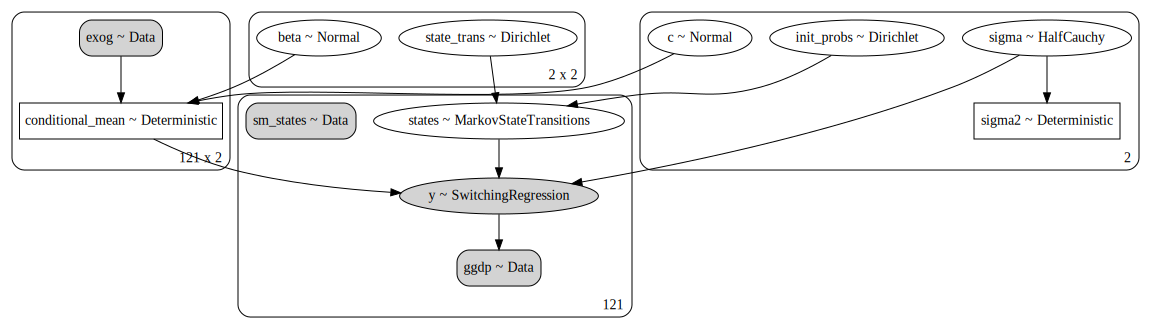

In [477]:
L = 2
T = len(train)

sm_states = (df_sm["prob_filtered"].dropna() >= 0.5).astype("int64").values

with pm.Model() as m:
    # Input data
    pm.Data("exog", exog[["t", "gesi[-4]"]].loc[train])
    pm.Data("ggdp", endog.loc[train])

    # States from Statsmodels model
    IntData("sm_states", sm_states)

    # Regression Coefficients
    pm.Normal(
        "c", mu=endog.mean(), sigma=10, shape=(L,),
    )
    pm.Normal("beta", mu=0, sigma=3, shape=(2, L))
    pm.HalfCauchy("sigma", shape=(L,), beta=3)
    pm.Deterministic("sigma2", m["sigma"] ** 2)

    # Markov switching Coefficients
    pm.Dirichlet("init_probs", a=tt.as_tensor([1, 1]), shape=L)
    pm.Dirichlet("state_trans", a=tt.as_tensor([[5, 5], [5, 5]]), shape=(L, L))

    # State process
    MarkovStateTransitions(
        "states",
        trans_prob=m["state_trans"],
        init_prob=m["init_probs"],
        shape=(T,),
        testval=m['sm_states'].get_value(),
        # observed=m['sm_states'],  # Comment if we want to 'learn' states
    )

    # Regression process
    sr = SwitchingRegression(
        "y",
        intercept=m["c"],
        coef=m["beta"],
        sigma=m["sigma"],
        states=m["states"],
        exog=m["exog"],
        shape=(T,),
        observed=m["ggdp"],
    )

pm.model_to_graphviz(m)

## Fit

In [478]:
with m:
    # prior = pm.sample_prior_predictive()
    trace = pm.sample(draws=1000, tune=2000, chains=2, cores=2, random_seed=101)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [state_trans, init_probs, sigma, beta, c]
>BinaryGibbsMetropolis: [states]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [04:40<00:00, 21.39draws/s]
The acceptance probability does not match the target. It is 0.9158406152767578, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [479]:
with m:
    ifd = az.from_pymc3(
        trace=trace,
        dims={
            # Coefficients
            'init_probs': ['STATE'],
            "state_trans": ["STATE", "AUX_STATE"],
            "c": ["STATE"],
            "beta": ["EXOG", "STATE"],
            # "beta_1": ["STATE"],  # old
            # "beta_2": ["STATE"],  # old
            "sigma": ["STATE"],
            "sigma2": ['STATE'],  # transformed
            
            # Values along time
            "ggdp": ["OBS"],
            "y": ["OBS"],
            "exog": ["OBS", "EXOG"],
            # 't': ["OBS"],  # old
            # 'gesi[-4]': ["OBS"],  # old
            
            # Auxilliary
            # 'states': ["OBS"],
            "conditional_mean": ["OBS", "STATE"],  
            # Helpers
            # 'sm_states': ["OBS"],
        },
        coords={
            "OBS": np.arange(T),
            "STATE": np.arange(L),
            "AUX_STATE": np.arange(L),
            "EXOG": ['t', 'gesi[-4]']
        },
        log_likelihood=False,  # This is broken
        
    )

These should be a reasonable mix. 
Regime 0: 85 
Regime 1: 36


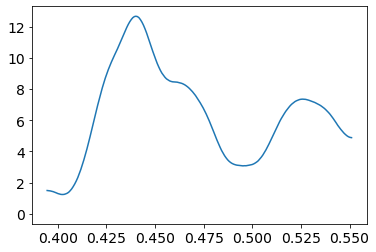

In [480]:
try:
    _st = ifd.posterior.mean(dim=["chain", "draw"])["states"]
    az.plot_dist(_st.values);
    print(
        "These should be a reasonable mix.",
        "\nRegime 0:",
        (_st <= 0.5).sum().item(),
        "\nRegime 1:",
        (_st > 0.5).sum().item(),
    )
except KeyError:
    pass

## Check coeffs

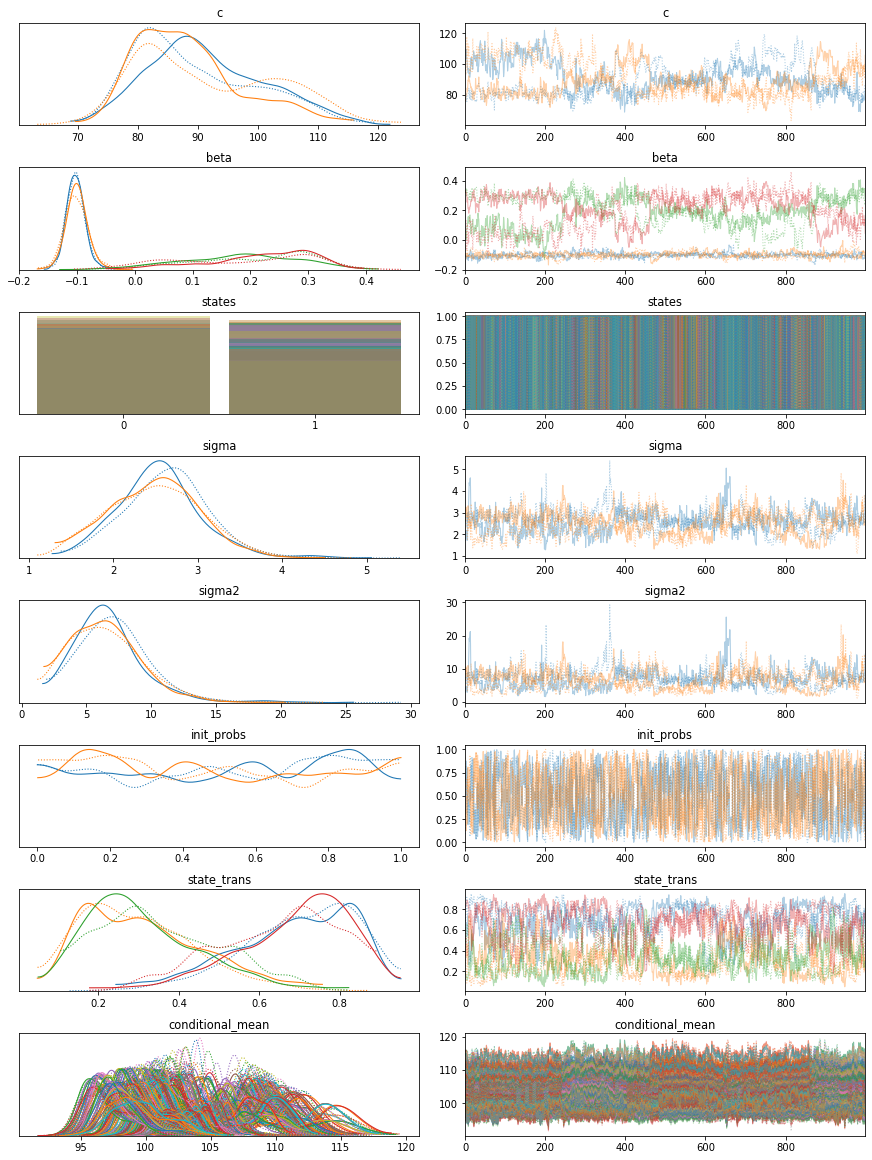

In [481]:
pm.traceplot(ifd);

In [483]:
post_mean = ifd.posterior.mean(dim=['chain','draw'])
post_mean

<xarray.Dataset>
Dimensions:           (AUX_STATE: 2, EXOG: 2, OBS: 121, STATE: 2, states_dim_0: 121)
Coordinates:
  * STATE             (STATE) int64 0 1
  * EXOG              (EXOG) <U8 't' 'gesi[-4]'
  * states_dim_0      (states_dim_0) int64 0 1 2 3 4 5 ... 116 117 118 119 120
  * AUX_STATE         (AUX_STATE) int64 0 1
  * OBS               (OBS) int64 0 1 2 3 4 5 6 ... 114 115 116 117 118 119 120
Data variables:
    c                 (STATE) float64 90.53 90.07
    beta              (EXOG, STATE) float64 -0.1027 -0.1007 0.1929 0.201
    states            (states_dim_0) float64 0.463 0.495 ... 0.3945 0.4325
    sigma             (STATE) float64 2.601 2.497
    sigma2            (STATE) float64 7.023 6.53
    init_probs        (STATE) float64 0.5138 0.4862
    state_trans       (STATE, AUX_STATE) float64 0.6912 0.3088 0.3363 0.6637
    conditional_mean  (OBS, STATE) float64 111.1 111.6 111.0 ... 98.21 98.82

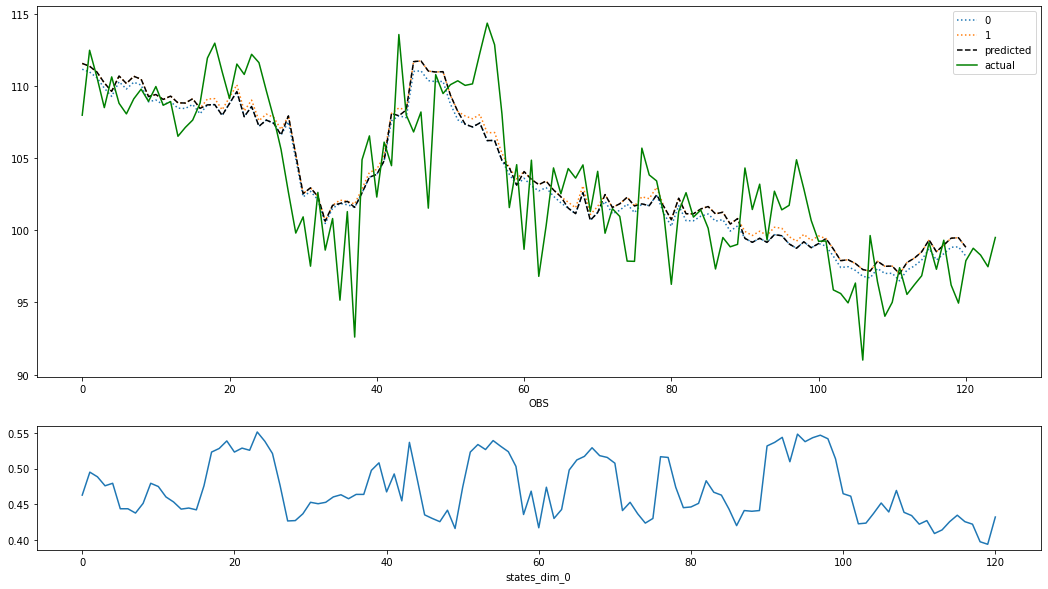

In [484]:
try:
    _state_mean = post_mean["states"].to_series()
except KeyError:
    _state_mean = ifd.observed_data["states"].to_series()

_cond_mean = post_mean["conditional_mean"].to_series().unstack("STATE")

_real_mean = pd.Series(np.diag(_cond_mean.loc[:, _qq]), _cond_mean.index)

fig, ax = plt.subplots(2, 1, figsize=(18, 10), gridspec_kw={"height_ratios": [3, 1]})

_cond_mean.plot(ax=ax[0], linestyle=':')
_real_mean.plot(ax=ax[0], color='black', linestyle='--', label='predicted')
endog.reset_index(drop=True).plot(ax=ax[0], color="green", label="actual")
ax[0].legend()

_state_mean.plot(ax=ax[1])
fig;